In [120]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [121]:
def parse_wrk_file(file):
    with open(file, "r") as f:
        text = f.read()

    server_type_match = re.search(r"Server type: (\w+)", text)
    server_type = server_type_match.group(1) if server_type_match else "Unknown"
    
    data = []
    for match in re.finditer(r"(\d+) connections.*?Latency\s*([\d\.]+[a-z]+).*?Requests/sec:\s*([\d\.]+).*?Transfer/sec:\s*([\d\.]+)[KMG]B", text, re.DOTALL):
        connections, latency, req_sec, transfer_sec = match.groups()
        data.append({
            "Server Type": server_type,
            "Connections": int(connections),
            "Requests/Sec": float(req_sec),
            "Transfer/Sec": float(transfer_sec) / int(connections),
            "Latency": latency
        })

    return pd.DataFrame(data)

In [122]:
# df_blocking = parse_wrk_file("up_to_10000/wrk_blocking_up_to_10000.txt")
# df_eventloop = parse_wrk_file("up_to_10000/wrk_eventloop_up_to_10000.txt")
# df_reactor = parse_wrk_file("up_to_10000/wrk_reactor_up_to_10000.txt")
# df_netty = parse_wrk_file("up_to_10000/wrk_netty_up_to_10000.txt")
# df_ktor = parse_wrk_file("up_to_10000/wrk_ktor_up_to_10000.txt")

In [123]:
df_blocking_up_to_10000 = parse_wrk_file("up_to_10000/wrk_blocking_up_to_10000_2.txt")
df_eventloop_up_to_10000 = parse_wrk_file("up_to_10000/wrk_eventloop_up_to_10000_3.txt")
df_reactor_up_to_10000 = parse_wrk_file("up_to_10000/wrk_reactor_up_to_10000.txt")
df_netty_up_to_10000 = parse_wrk_file("up_to_10000/wrk_netty_up_to_10000_2.txt")
df_ktor_up_to_10000 = parse_wrk_file("up_to_10000/wrk_ktor_up_to_10000_4.txt")

df_eventloop_after_10000 = parse_wrk_file("after_10000/wrk_eventloop_after_10000.txt")
df_reactor_after_10000 = parse_wrk_file("after_10000/wrk_reactor_after_10000.txt")
df_netty_after_10000 = parse_wrk_file("after_10000/wrk_netty_after_10000.txt")
df_ktor_after_10000 = parse_wrk_file("after_10000/wrk_ktor_after_10000.txt")

df_ktor_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_ktor__22_04.txt")
df_asm_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_asm__22_04.txt")
df_eventloop_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_eventloop__22_04.txt")
df_reactor_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_reactor__22_04.txt")
df_blocking_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_blocking__22_04.txt")
df_netty_22_04 = parse_wrk_file("local_from_1_to_3000/local_from_1_to_3000/wrk_netty__22_04.txt")

# df_blocking_after_10000 = df_blocking[df_blocking["Connections"] > 1000]
# df_eventloop_after_10000 = df_eventloop[df_eventloop["Connections"] > 1000]
# df_reactor_after_10000 = df_reactor[df_reactor["Connections"] > 1000]
# df_netty_after_10000 = df_netty[df_netty["Connections"] > 1000]
# df_ktor_after_10000 = df_asm[df_asm["Connections"] > 1000]

In [124]:
def plot_graph(df): 
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))
    
    server_type = df["Server Type"].iloc[0]
    points_size=10
    
    axs[0].scatter(df["Connections"], df["Requests/Sec"], s=points_size)
    axs[0].set_xlabel("Connections")
    axs[0].set_ylabel("Requests/Sec")
    axs[0].set_title(f"{server_type} server: Connections vs Requests/Sec")
    
    axs[1].scatter(df["Connections"], df["Transfer/Sec"], s=points_size)
    axs[1].set_xlabel("Connections")
    axs[1].set_ylabel("Transfer/Sec")
    axs[1].set_title(f"{server_type} server: Connections vs Transfer/Sec")
    
    plt.tight_layout()
    plt.show()
    
def plot_graph_interval(df): 
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))
    
    server_type = df["Server Type"].iloc[0]
    unique_connections = df["Connections"].unique()
    unique_connections.sort()

    for ax, column in zip(axs, ["Requests/Sec", "Transfer/Sec"]):
        means = [np.mean(df[df["Connections"] == x][column]) for x in unique_connections]
        confidences = [stats.sem(df[df["Connections"] == x][column]) * stats.t.ppf((1 + 0.95) / 2., df[df["Connections"] == x][column].count()-1) for x in unique_connections]

        ax.plot(unique_connections, means)
        ax.fill_between(unique_connections, np.subtract(means, confidences), np.add(means, confidences), color='b', alpha=.1)
        ax.set_xlabel("Connections")
        ax.set_ylabel(column)
        ax.set_title(f"{server_type} server: Connections vs {column}")

    plt.tight_layout()
    plt.show()

    
def plot_graphs(*dfs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))
    
    for df in dfs:
        server_type = df["Server Type"].iloc[0]
        unique_connections = df["Connections"].unique()
        unique_connections.sort()
    
        for ax, column in zip(axs, ["Requests/Sec", "Transfer/Sec"]):
            means = [np.mean(df[df["Connections"] == x][column]) for x in unique_connections]
            confidences = [stats.sem(df[df["Connections"] == x][column]) * stats.t.ppf((1 + 0.95) / 2., df[df["Connections"] == x][column].count()-1) for x in unique_connections]
            ax.plot(unique_connections, means, label=server_type)
            ax.fill_between(unique_connections, np.subtract(means, confidences), np.add(means, confidences), alpha=.1)
            ax.set_xlabel("Connections")
            ax.set_ylabel(column)
            ax.set_title(f"Connections vs {column}")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_with_confidence_interval_columns(x_column, y_column, *dfs):
    plt.figure(figsize=(10, 6))
    
    for df in dfs:
        server_type = df["Server Type"].iloc[0]
        grouped = df.groupby(x_column)[y_column].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        
        margin_error = grouped['sem'] * stats.t.ppf((1 + 0.9) / 2.0, grouped['count'] - 1)
        grouped['lower_ci'] = grouped['mean'] - margin_error
        grouped['upper_ci'] = grouped['mean'] + margin_error
        
        plt.errorbar(grouped.index, grouped['mean'], fmt='-o', label=server_type)
        plt.fill_between(grouped.index, grouped['lower_ci'], grouped['upper_ci'], alpha=0.2)
        
    plt.xlabel("Соединения")
    plt.ylabel("Запросы в секунду")
    plt.title("Сравнение решений")
    plt.legend()
    plt.grid(True)
    plt.show()  
    
def plot_with_confidence_interval_connections_throughput(*dfs):
    return plot_with_confidence_interval_columns("Connections", "Requests/Sec", *dfs)

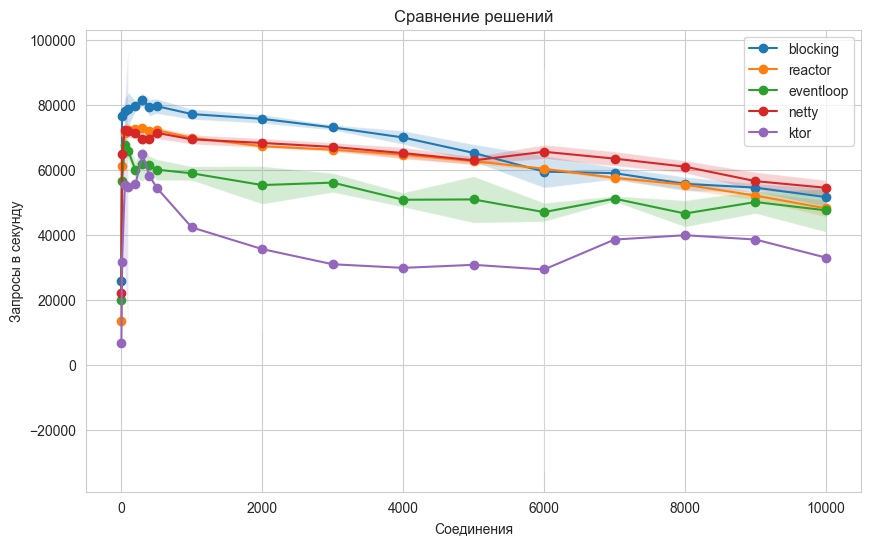

In [125]:
plot_with_confidence_interval_connections_throughput(
    df_blocking_up_to_10000, 
    df_reactor_up_to_10000, 
    df_eventloop_up_to_10000, 
    df_netty_up_to_10000, 
    df_ktor_up_to_10000
)

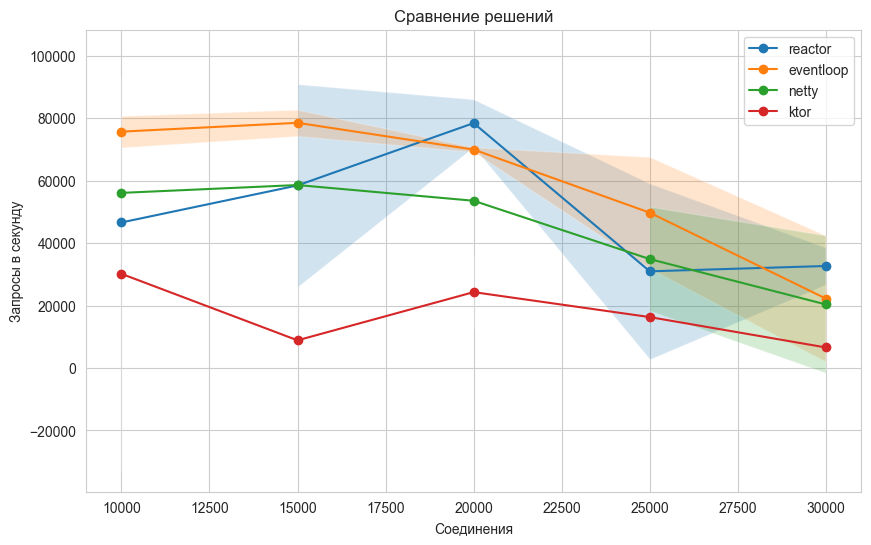

In [126]:
plot_with_confidence_interval_connections_throughput(
    df_reactor_after_10000,
    df_eventloop_after_10000, 
    df_netty_after_10000, 
    df_ktor_after_10000
)

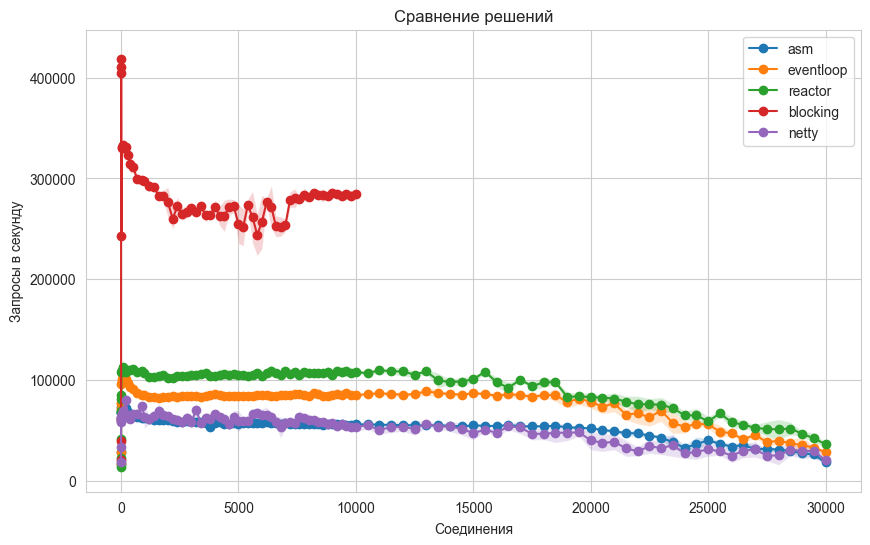

In [131]:
plot_with_confidence_interval_connections_throughput(
    df_asm_22_04,
    # df_ktor_22_04,
    df_eventloop_22_04,
    df_reactor_22_04,
    df_blocking_22_04,
    df_netty_22_04,
)

In [128]:
df_eventloop_22_04

,Server Type,Connections,Requests/Sec,Transfer/Sec,Latency
0,eventloop,1,16260.17,48.270000,70.09us
1,eventloop,1,16236.83,48.200000,68.59us
2,eventloop,1,16503.37,49.000000,68.53us
3,eventloop,1,16474.10,48.910000,68.40us
4,eventloop,1,16393.13,48.670000,65.96us
...,...,...,...,...,...
515,eventloop,30000,24212.73,0.002396,180.13ms
516,eventloop,30000,29081.08,0.002878,176.78ms
517,eventloop,30000,25516.02,0.002525,188.82ms
518,eventloop,30000,32030.66,0.003170,152.28ms
